# grouping

In [10]:
%load_ext autoreload
%autoreload 2

from bezier_utils import *
from english_encoding import *
from fitCurves import *
from GrouperData import *
from GrouperModel import *
import english_encoding as Encoding

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
grouper = GrouperDataset("train_images")
grouper.load_annotations_from_file("train_96voc_embed.json")

train_set, test_set = grouper.get_train_test_set(train_ratio=0.9, sample_ratio=1.0, random_seed=5)

KeyboardInterrupt: 

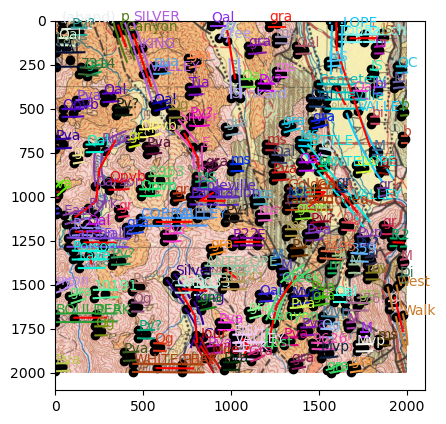

In [13]:
grouper = GrouperDataset("train_images")

grouper.load_annotations_from_file("train_96voc_embed.json")

grouper.draw_annotations(100, Encoding.decode_text_96)

In [2]:
grouper = GrouperDataset("train_images")

grouper.load_annotations_from_file("train_96voc_embed.json")

#sorter.gen_font_embed_all('models/DeepFontEncoder.pth', 'cuda')

#sorter.save_annotations_to_file("dataset/sorter/train_96voc_embed.json")
image_id = 9

samples = grouper.sample(image_id, 1, closest_pts_count=15, non_overlap=True)

# grouper.draw_sample(image_id, samples[0], Encoding.decode_text_96)

In [10]:
samples[0]['word'].keys()

dict_keys(['rec', 'bezier', 'center', 'group_id', 'id_in_group', 'font_embed'])

In [8]:
samples[0]['dictionary'][0].keys()

dict_keys(['rec', 'bezier', 'center', 'group_id', 'id_in_group', 'font_embed'])

In [7]:
samples[0]['word']['center']

[39.51489309809861, 673.6879540288799]

In [9]:
grouper = GrouperDataset("train_images")
grouper.load_annotations_from_file("train_96voc_embed.json")

train_set, test_set = grouper.get_train_test_set(train_ratio=0.9, sample_ratio=0.1, random_seed=5)
train_set = DatasetClass(train_set)
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)
test_set = DatasetClass(test_set)
test_dataloader = DataLoader(test_set, batch_size=1, shuffle=False)

model = GrouperTransformerEncoderNoFont()
# model = GrouperTransformerEncoderDecoderLinearNoFont()
if model.type == 'GrouperTransformerEncoderDecoderLinearNoFont':
    criterion = nn.CrossEntropyLoss(ignore_index=18)
else:
    criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train(model, train_dataloader, test_dataloader, optimizer, criterion, 1, device)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "D:\anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Theodore\AppData\Local\Temp\ipykernel_2576\2014913028.py", line 10, in <module>
    model = GrouperTransformerEncoderNoFont()
  File "D:\codes\semester_project_24spring_georeferencing\semester_project_code\grouper\GrouperModel.py", line 177, in __init__
    super(GrouperTransformerEncoderNoFont, self).__init__()
TypeError: super(type, obj): obj must be an instance or subtype of type

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "D:\anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "D:\anaconda3\envs\ada\lib\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.str

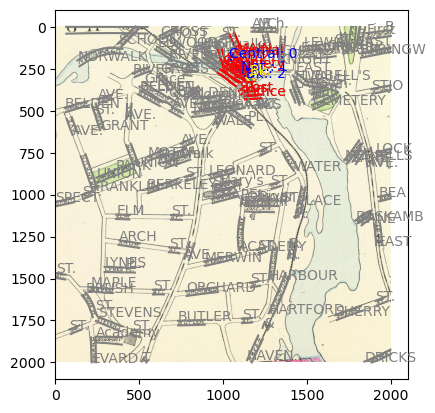

In [19]:
img_id = 42

samples = grouper.sample(img_id, 1)

grouper.draw_sample(img_id, samples[0], decode_text_96)

# reordering

In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained model and tokenizer
model_name = 'gpt2'
model = GPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Function to calculate probability of a text
def get_probability(text):
    tokens = tokenizer.encode(text, return_tensors='pt')
    loss = model(tokens, labels=tokens)[0]
    return torch.exp(-loss).item()

# List of permutations
permutations = ["de Triumph Arc", "Arc Triumph de", "Triumph Arc de"]

# Calculate and print the probability for each permutation
probabilities = {p: get_probability(p) for p in permutations}
best_permutation = max(probabilities, key=probabilities.get)

print("Probabilities:", probabilities)
print("Best permutation:", best_permutation)


In [ ]:
from transformers import BertTokenizer, BertForMaskedLM
import torch

# Load BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')
model.eval()

# Function to calculate the probability of a masked word given the other words
def masked_probability(sentence, mask_index):
    tokens = tokenizer.tokenize(sentence)
    tokens[mask_index] = '[MASK]'
    ids = tokenizer.convert_tokens_to_ids(tokens)
    ids = torch.tensor([ids])
    
    with torch.no_grad():
        outputs = model(ids)
        predictions = outputs[0]
    
    masked_token_id = tokenizer.convert_tokens_to_ids([tokenizer.tokenize(sentence)[mask_index]])[0]
    predicted_prob = torch.nn.functional.softmax(predictions[0, mask_index], dim=-1)[masked_token_id].item()
    
    return predicted_prob

# Calculate the joint probability of a permutation
def joint_probability(permutation):
    words = permutation.split()
    probability = 1.0
    for i in range(len(words)):
        probability *= masked_probability(permutation, i)
    return probability

# Example permutations
permutations = ["de Triumph Arc", "Arc Triumph de", "Triumph Arc de"]

# Calculate probabilities
probabilities = {p: joint_probability(p) for p in permutations}
best_permutation = max(probabilities, key=probabilities.get)

print("Probabilities:", probabilities)
print("Best permutation:", best_permutation)
